## Maximum Cabinets Covering Location Problem (MBCLP) solved by Gurobi

In [41]:
from gurobipy import *

In [42]:
def gurobi_solver_MCLP(users, facilities, demand, PN, A):
    # Problem datas
    N = len(users)
    M = len(facilities)

    model = Model('MCLP')
    model.setParam('OutputFlag', False)
    model.setParam('MIPFocus', 2)
    # Add variables
    client_var = {}
    serv_var = {}

    # Add Client Decision Variables and Service Decision Variables
    for j in range(N):
        client_var[j] = model.addVar(vtype="B", name="y(%s)"%j)
    for i in range(M):
        serv_var[i] = model.addVar(vtype="B", name="x(%s)"%i)
    # Update Model Variables
    model.update()
    #     Set Objective Function
    model.setObjective(quicksum(demand[j]*client_var[j] for j in range(N)), GRB.MAXIMIZE)
    #     Add Constraints
    # Add Coverage Constraints
    for j in range(N):
        model.addConstr(quicksum (A[i,j]*serv_var[i] for i in range(M)) - client_var[j] >= 0,
                        'Coverage_Constraint_%d' % j)

    # Add Facility Constraint
    model.addConstr(quicksum(serv_var[i] for i in range(M)) == PN,
                "Facility_Constraint")

    model.optimize()

    # return a stardard result list
    x_result = []
    for i in range(M):
        x_result.append(serv_var[i].X)
    y_result = []
    for j in range(N):
        y_result.append(client_var[j].X)
    obj = model.ObjVal
    return x_result, y_result, obj

## Load the real-world datasets

In [43]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [44]:
%%time
ls = gpd.read_file("./data/data/real/福田区car-share/demand.shp")
ls['POINT_X'] = ls.geometry.x
ls['POINT_Y'] = ls.geometry.y
ls.head(3)
# ls['speed_pct_freeflow_rev'] = ls.pct_from_f * (-1)
# total_pop = sum(ls['speed_pct_freeflow_rev'])
# print("The number of records is ", len(ls))
# print("The total speed unit are ", total_pop)

Wall time: 321 ms


,demand,POINT_X,POINT_Y,geometry
0,0.071082,813513.945347,2.491772e+06,POINT (813513.945 2491772.476)
1,0.070170,813713.945347,2.491772e+06,POINT (813713.945 2491772.476)
2,0.073825,813913.945347,2.491772e+06,POINT (813913.945 2491772.476)


### Candidate Billboard Location
Billboards data were retrieved from LAMAR

In [45]:
sitedf = gpd.read_file("./data/data/real/福田区car-share/sheshidian.shp")
# sitedf = pd.read_csv("./data/real/billboards_nyc.csv")
# sites = np.array(sitedf[['NORM_X', 'NORM_Y']], dtype=np.float64)
print("The number of billboards in Seattle area is ", len(sitedf))
sitedf.head(3)

The number of billboards in Seattle area is  159


,name,wgs84_lng,wgs84_lat,ad,POINT_X,POINT_Y,geometry
0,城联物流大厦停车场,114.05122954110132,22.504835668206958,福田区,813929.210967,2.491908e+06,POINT (813929.211 2491908.493)
1,福星惠誉大楼停车场,114.0453673944444,22.506250001610663,福田区,813322.481139,2.492053e+06,POINT (813322.481 2492052.905)
2,万乘储运大厦东停车场,114.05424587697357,22.506859313719318,福田区,814235.179592,2.492139e+06,POINT (814235.180 2492139.062)


## Normalization

In [46]:
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [47]:
ls_X = np.array(ls['POINT_X'])
ls_Y = np.array(ls['POINT_Y'])
bbs_X = np.array(sitedf['POINT_X'])
bbs_Y = np.array(sitedf['POINT_Y'])
X = np.concatenate([ls_X, bbs_X])
Y = np.concatenate([ls_Y, bbs_Y])
NORM_X, NORM_Y, S = Normalization(X, Y)
ls['NORM_X'] = NORM_X[:len(ls)]
ls['NORM_Y'] = NORM_Y[:len(ls)]
sitedf['NORM_X'] = NORM_X[len(ls):]
sitedf['NORM_Y'] = NORM_Y[len(ls):]

In [48]:
sitedf.head(3)

,name,wgs84_lng,wgs84_lat,ad,POINT_X,POINT_Y,geometry,NORM_X,NORM_Y
0,城联物流大厦停车场,114.05122954110132,22.504835668206958,福田区,813929.210967,2.491908e+06,POINT (813929.211 2491908.493),0.572792,0.012144
1,福星惠誉大楼停车场,114.0453673944444,22.506250001610663,福田区,813322.481139,2.492053e+06,POINT (813322.481 2492052.905),0.518619,0.025038
2,万乘储运大厦东停车场,114.05424587697357,22.506859313719318,福田区,814235.179592,2.492139e+06,POINT (814235.180 2492139.062),0.600110,0.032731


### Visualization of the input data

In [49]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [50]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [51]:
sitedf1 = sitedf[sitedf['POINT_X'] < max(ls['POINT_X'])]
sitedf1 = sitedf1[sitedf1['POINT_X'] > min(ls['POINT_X'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] < max(ls['POINT_Y'])]
sitedf1 = sitedf1[sitedf1['POINT_Y'] > min(ls['POINT_Y'])]

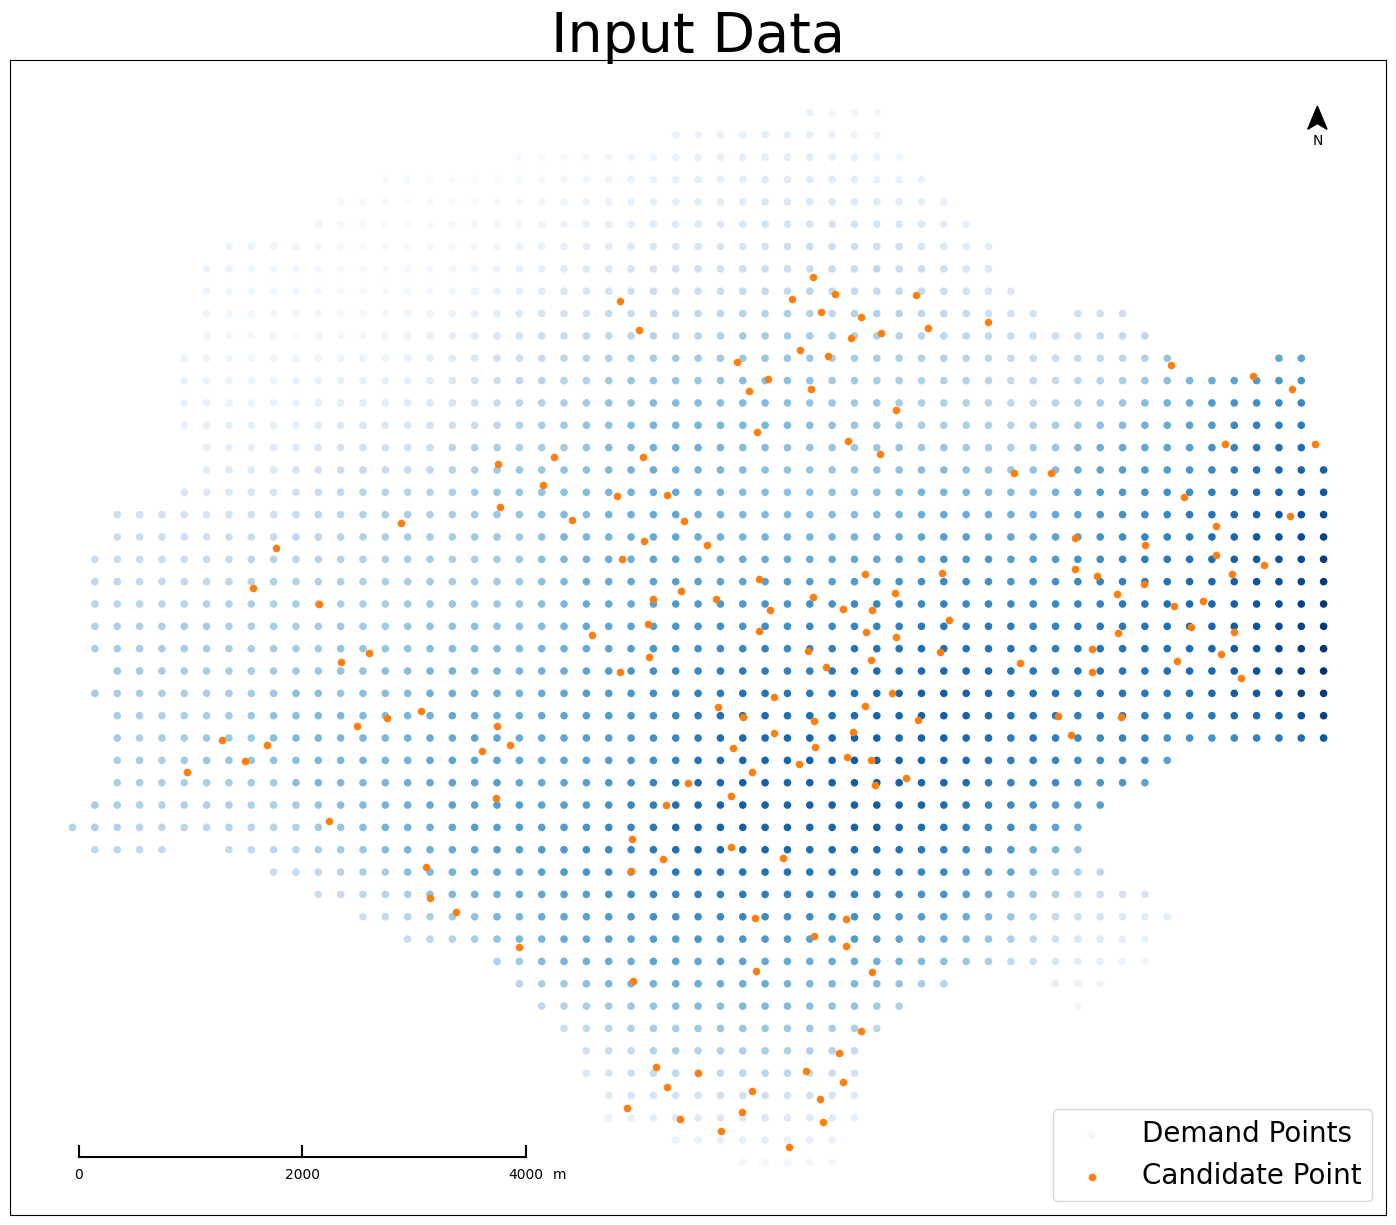

Wall time: 3.59 s


In [52]:
%%time
fig, ax = plt.subplots(figsize=(20,15))
# ax.scatter(ls['POINT_X'],ls['POINT_Y'], color='Blue', s=ls['speed_pct_freeflow_rev'])
ls.plot(ax = ax, column=ls['demand'], k=5, markersize=20, cmap='Blues', label = 'Demand Points')
ax.scatter(sitedf1['POINT_X'], sitedf1['POINT_Y'], c='C1', s=20, label = 'Candidate Point')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=40)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1, fontsize=20)
plt.savefig('./picture/Input.jpg', dpi=600)
plt.show()

In [53]:
def generate_candidate_sites(sites, M=100, heuristic = None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic:
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [58]:
def plot_result(ls,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20,15))
    ls.plot(ax = ax, column=ls['demand'], k=5, markersize=5, cmap='Blues', label = 'Demand Points')
    legend_plot_flag = {'current':False,'selected':False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:#ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=1, label = 'Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
#             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=10, label = 'Optimized Selected Cars')
                circlelabel = 'Service Range for Optimized Selected Cars'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
#             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2)
            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m'+ ' by Gurobi'
    ax.set_title(title, fontsize=40)
    render_scale_bar(ax = ax, x=0.05, y=0.05)
    render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
    ax.legend(loc='lower right', markerscale=4, fontsize=20)
    return ax

In [59]:
np.random.seed()
bbs_ = generate_candidate_sites(sitedf, M=None, heuristic="")
users = np.array(ls[['NORM_X', 'NORM_Y']])
facilities = np.array(bbs_[['NORM_X', 'NORM_Y']])
# demand = np.array(ls['speed_pct_freeflow_rev_norm'])
demand = np.array(ls['demand'])

p = 30
real_radius = 500
radius = real_radius/S
A = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
mask1 = A <= radius
A[mask1] = 1
A[~mask1] = 0

In [60]:
%%time
x_result, y_result, obj = gurobi_solver_MCLP(users, facilities, demand, p, A)
print(f"The avg objective of MCLP samples is: {obj}")
solutions = []
for i in range(len(bbs_)):
    if x_result[i] == 1.0:
        solutions.append(i)
solutions


The avg objective of MCLP samples is: 273.32729100000006
Wall time: 9.37 s


[15,
 17,
 19,
 24,
 25,
 28,
 33,
 35,
 36,
 47,
 55,
 56,
 57,
 59,
 62,
 66,
 68,
 70,
 82,
 89,
 90,
 96,
 107,
 111,
 116,
 120,
 121,
 125,
 133,
 136]

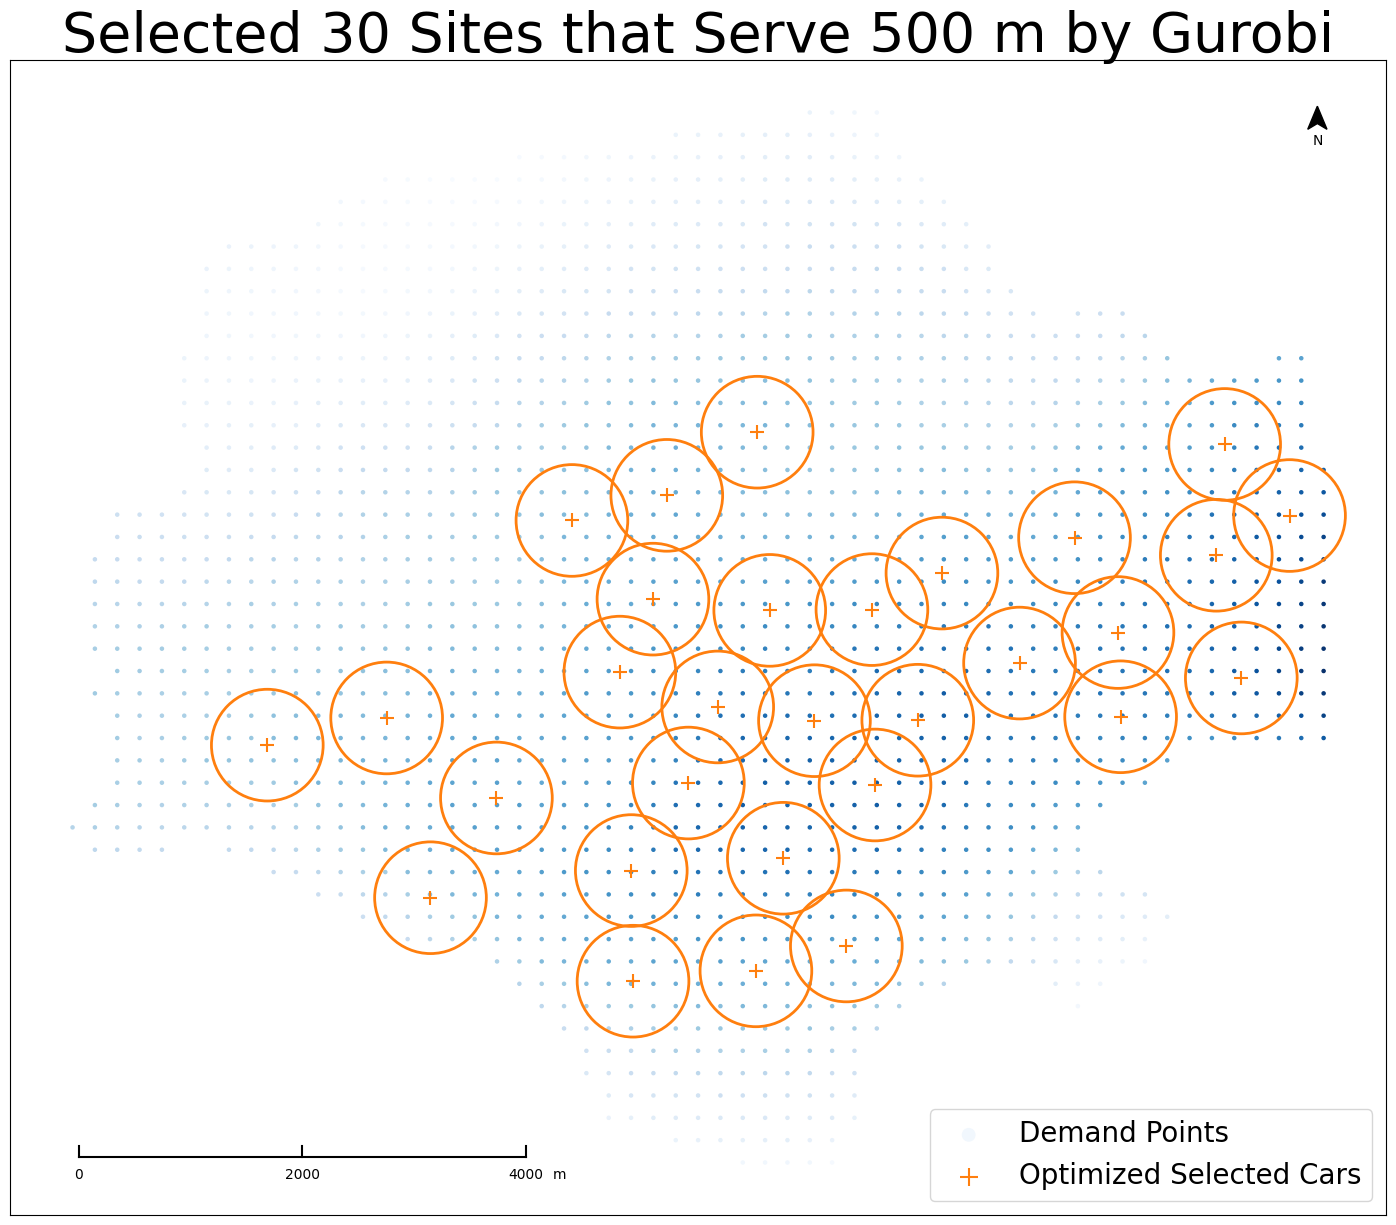

In [61]:
opt_sites = bbs_.iloc[solutions]
plot_result(ls,opt_sites,real_radius)
plt.savefig('./picture/Gurobi_MCLP.jpg', dpi=600)
plt.show()